In [32]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# from sklearnex import patch_sklearn 
# patch_sklearn()


# Ridge Regression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

# Randomforest Regression
from sklearn.ensemble import RandomForestRegressor

# Support Vector Regression
from sklearn.svm import SVR

# hyper parameter tunning
from sklearn.model_selection import GridSearchCV

# ARIMA
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

# LSTM
# from sklearn.preprocessing import MinMaxScaler
# from keras.models import Sequential
# from keras.layers import Dense, Dropout
# from keras.layers import LSTM

from sklearn.model_selection import train_test_split


In [59]:
# -*- coding: utf-8 -*-
"""
Created on Sun Jul 31 16:43:28 2022

@author: Junhyun
"""
class TimeSeriesRegression():
    
    def __init__(self):
        self.data = None
    
    def TimeSeriesDataTransform(self, data, lag):
        """
        # 참조 코드 : http://103.60.126.183:8150/gidatalab (LSTM)
        
        데이터를 변환하기 위해서는 Y값이 맨 왼쪽에 위치해있어야함 
        
        To transoform data to timeseries data, target data(Y) have to be located at leftmost
    
        Parameters
        ----------
        data : DataFrame
            data
        lag : int
            시계열 예측에서 데이터를 미는 시점 (= Time sequence)

        Returns
        -------
        agg : 시계열 에측이 가능하도록 변환된 데이터

        """
        if isinstance(self.data, np.ndarray):
            data = pd.DataFrame(self.data)
        elif isinstance(self.data, pd.core.series.Series):
            data = pd.DataFrame(self.data)
        
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)

        cols, names = list(), list()

        # 입력값의 순서 (t-n, ... t-1)
        for i in range(lag, 0, -1):
            cols.append(df.shift(i))
            names += [('%s(t-%d)' % (data.columns[j], i)) for j in range(n_vars)]

        # 예측의 순서 (t, t+1, ... t+n)
        for i in range(0, 1):
            cols.append(df.shift(-i))
            if i == 0:
                names += [('%s(t)' % (data.columns[j])) for j in range(n_vars)]
            else:
                names += [('%s(t+%d)' % (data.columns[j], i)) for j in range(n_vars)]

        # 합치기
        agg = pd.concat(cols, axis=1)
        agg.columns = names

        # NaN 값의 row를 제거
        agg.dropna(inplace=True)
        
        # 인덱스 초기화
        agg = agg.reset_index(drop=True)
        
        agg = agg.iloc[:,0:(data.shape[1]*lag)+1]

        return agg

        
    # Ridge Regression
    def Ridge_regression(self, X_train, X_test, y_train, y_test):

        alphas = np.arange(0.01, 1, 0.03)
        ridgecv = RidgeCV(alphas = alphas, cv = 5) 
        ridgecv.fit(X_train, y_train)
        print("alpha : %.2f" % ridgecv.alpha_)

        ridge_train_pred = ridgecv.predict(X_train)
        ridge_test_pred = ridgecv.predict(X_test)

        return({'trainPrediction':ridge_train_pred, 'testPrediction':ridge_test_pred})
    
    # Random Forest Regression
    def Randomforest_regression(self, X_train, X_test, y_train, y_test):

        params = {
            'n_estimators' : [100],
            'max_depth' : [6,8,10,12],
            'min_samples_leaf' : [8,12,8],
            'min_samples_split' : [8,16,20]
        }

        rf = RandomForestRegressor()
        grid_cv = GridSearchCV(rf, param_grid=params, cv=5)
        grid_cv.fit(X_train, y_train)
        print("최적 하이퍼 파라미터:\n", grid_cv.best_params_)

        rf_train_pred = grid_cv.predict(X_train)
        rf_test_pred = grid_cv.predict(X_test)

        return({'trainPrediction':rf_train_pred, 'testPrediction':rf_test_pred})
    
    # Support Vector Regression
    def Supportvector_regression(self, X_train, X_test, y_train, y_test):

        param_grid = [
            {'kernel':['linear'], 'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]},
            {'kernel':['rbf'], 'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]},
            {'gamma':[0.0001, 0.001, 0.01, 0.1, 1.0]}
        ]
        svr = SVR()
        grid_cv = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
        grid_cv.fit(X_train, y_train)
        print("최적 하이퍼 파라미터:\n", grid_cv.best_params_)

        svr_train_pred = grid_cv.predict(X_train)
        svr_test_pred = grid_cv.predict(X_test)

        return({'trainPrediction':svr_train_pred, 'testPrediction':svr_test_pred})
    
    # ARIMA
    def ARIMA_model(self, y_train, n_periods=5):

        auto_arima_model = auto_arima(y_train, 
                                      start_p=0, max_p=10, 
                                      start_q=0, max_q=10, 
                                      seasonal=False,
                                      d=1,
                                      trace=False,
                                      error_action='ignore',  
                                      suppress_warnings=True, 
                                      stepwise=False,
                            )
        auto_arima_model.fit(y_train)
        arima_test_pred = auto_arima_model.predict(n_periods=n_periods)

        print(auto_arima_model)

        return({'testPrediction':arima_test_pred})

    def LSTM_model(self, X_train, X_test, y_train, y_test, epochs=50):
        """

        Parameters
        ----------
        X_train : Array
            Train input data, shape=(nrow, lag, ncol)
        X_test : Array
            Test input data, shape=(nrow, lag, ncol)
        y_train : Array
            Train input data, shape=(nrow,)
        y_test : Array
            Train input data, shape=(nrow,)
        epochs : int
            LSTM 학습횟수

        Returns
        -------
        trainPrediction : Array
            Train Prediction
        testPrediction : Array
            Test Prediction

        """


        # LSTM의 구조
        model = Sequential()
        model.add(LSTM(8, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu')) # 하나의 층 8개의 노드, return_sequences=True 필수
        model.add(LSTM(4, activation='relu', return_sequences=False)) # 하나의층, 4개의 노드, 마지막에는 return_sequences=False
        model.add(Dense(1)) # 노드가 하나인 구조를 만들었다 (하나의 예측값으로 표현하기 위해)

        # model compile
        model.compile(loss='mse', optimizer='adam')

        # fit network
        history = model.fit(X_train, y_train, epochs=epochs, verbose=0, shuffle=False) # epochs : 반복횟수

        lstm_train_pred = model.predict(X_train)
        lstm_test_pred = model.predict(X_test)

        return({'trainPrediction':lstm_train_pred, 'testPrediction':lstm_test_pred})

In [60]:
"""
Created on Sun Jul 31 20:18:12 2022

@author: Junhyun
"""

class Recursive_Bayesian_Ensemble_Model(TimeSeriesRegression):
    
    def __init__(self):
        super().__init__()
        
        
    def EnsembleWeight(self, y_test, ensembleModel):
        
        # test loss of each prediction model
        ridge_mse = mean_squared_error(y_test, ensembleModel['ridgeTestPrediction'])
        rf_mse = mean_squared_error(y_test, ensembleModel['rfTestPrediction'])
        svr_mse = mean_squared_error(y_test, ensembleModel['svrTestPrediction'])
        arima_mse = mean_squared_error(y_test, ensembleModel['arimaTestPrediction'])

        # Fitness weight of each model
        fitnessSum = (1/ridge_mse + 1/rf_mse + 1/svr_mse + 1/arima_mse) # MSE -> fitness Weight
        ridge_fitWeight = (1/ridge_mse)  / fitnessSum
        rf_fitWeight = (1/rf_mse)  / fitnessSum
        svr_fitWeight = (1/svr_mse) / fitnessSum
        arima_fitWeight = (1/arima_mse) / fitnessSum
        
        fitWeight = {'Ridge_FitWeight' : ridge_fitWeight, 'RF_FitWeight':rf_fitWeight, 'SVR_FitWeight' : svr_fitWeight, 'ARIMA_FitWeight' : arima_fitWeight}
        
        return(fitWeight)
    
    def EnsemblePrediction(self, X_train, X_test, y_train, y_test, fitWeight):
    
        ridge = super().Ridge_regression(X_train, X_test, y_train, y_test)
        rf = super().Randomforest_regression(X_train, X_test, y_train, y_test)
        svr = super().Supportvector_regression(X_train, X_test, y_train, y_test)
        arima = super().ARIMA_model(y_train, y_test.shape[0])
        
        RBEM_train_pred = (ridge['trainPrediction'] * fitWeight['Ridge_FitWeight']) + (rf['trainPrediction'] * fitWeight['RF_FitWeight']) + (svr['trainPrediction'] * fitWeight['SVR_FitWeight'])
        RBEM_test_pred = (ridge['testPrediction'] * fitWeight['Ridge_FitWeight']) + (rf['testPrediction'] * fitWeight['RF_FitWeight']) + (svr['testPrediction'] * fitWeight['SVR_FitWeight'])+ arima['testPrediction'] * fitWeight['ARIMA_FitWeight']
        
        return(
            {
             'trainPrediction' : RBEM_train_pred, 'testPrediction':RBEM_test_pred, 
             'ridgeTrainPrediction':ridge['trainPrediction'], 'ridgeTestPrediction':ridge['testPrediction'],
             'rfTrainPrediction' : rf['trainPrediction'], 'rfTestPrediction' : rf['testPrediction'],
             'svrTrainPrediction' : svr['trainPrediction'], 'svrTestPrediction' : svr['testPrediction'],
            'arimaTestPrediction' : arima['testPrediction']
            }
        )
    
    # Recursive Bayesian Update
    def BayesianUpdate(self, Prior, Likelihood):
        
        posterior_Sum = Prior['Ridge_FitWeight']*Likelihood['Ridge_FitWeight'] + Prior['RF_FitWeight']*Likelihood['RF_FitWeight']+Prior['SVR_FitWeight']*Likelihood['SVR_FitWeight'] + Prior['ARIMA_FitWeight']*Likelihood['ARIMA_FitWeight']
        Ridge_Updated_Weight = Prior['Ridge_FitWeight']*Likelihood['Ridge_FitWeight'] / posterior_Sum
        RF_Updated_Weight = Prior['RF_FitWeight']*Likelihood['RF_FitWeight'] / posterior_Sum
        SVR_Updated_Weight = Prior['SVR_FitWeight']*Likelihood['SVR_FitWeight'] / posterior_Sum
        ARIMA_Updated_Weight =  Prior['ARIMA_FitWeight']*Likelihood['ARIMA_FitWeight'] / posterior_Sum

        updatedFitWeight = {'Ridge_FitWeight' : Ridge_Updated_Weight, 'RF_FitWeight':RF_Updated_Weight, 'SVR_FitWeight' : SVR_Updated_Weight, 'ARIMA_FitWeight':ARIMA_Updated_Weight}
        
        return(updatedFitWeight)
    
    # Recursive Bayesian Ensemble Model
    def RBEM_model(self, X, y, trainCycle=10, predictionCycle=5, Cycle=5):
        """

        Parameters
        ----------
        X : Array  
            Input data, shape=(nrow, lag, ncol)
        y : Array
            Output data, shape=(nrow,)
        trainCycle : int
            며칠 주기로 학습할 것인지 
        predictionCycle : int
            며칠 주기로 예측할 것인지
        Cycle : int
            위 과정을 몇번 반복할 것인지

        Returns
        -------
        recursive_test_pred : Array
            test 데이터를 recursive하게 예측한 결과


        예시)
        1row = 1일일때, 
        trainCycle = 5 -> 5일 주기로 학습
        predictionCycle = 2 -> 2일 주기로 예측

        1월 1일 데이터가 있다고 가정

        - 1월 1일 ~ 1월 5일 (5일) 학습 후, 1월 6일~1월 7일 (2일) 예측 (1cycle)
        - 1월 3일 ~ 1월 7일 (5일) 학습 후, 1월 8일~1월 9일 (2일) 예측 (2cycle) (1월 6일은 실제 데이터임 (예측한 데이터 X)) (현재시점까지 왔다고 가정)
        - 1월 5일 ~ 1월 9일 (5일) 학습 후, 1월 10일~1월 11일 (2일) (1일) 예측 (3cycle) (1월 7일은 실제 데이터임 (예측한 데이터 X)) (현재시점까지 왔다고 가정)


        """
        
        # Recursive Prediction
        RBEM_test_pred = np.array([])
        Ridge_test_pred = np.array([])
        RF_test_pred = np.array([])
        SVR_test_pred = np.array([])
        ARIMA_test_pred = np.array([])
        y_test = np.array([])
        
        # Prior of Ensemble Weight
        prior_fitWeight = {'Ridge_FitWeight' : 1/3, 'RF_FitWeight':1/3, 'SVR_FitWeight' : 1/3, 'ARIMA_FitWeight':1/3}
        
        for i in range(Cycle):

            # Recursive prediction
            recursive_X_train = X[(predictionCycle*i):(trainCycle+predictionCycle*i)]
            recursive_X_test = X[(trainCycle+predictionCycle*i):(trainCycle+predictionCycle*(i+1))]
            
            recursive_y_train = y[(predictionCycle*i):(trainCycle+predictionCycle*i),]
            recursive_y_test = y[(trainCycle+predictionCycle*i):(trainCycle+predictionCycle*(i+1)),]
            
            y_test = np.append(y_test, recursive_y_test.values)
            
            ensemble_pred = self.EnsemblePrediction(recursive_X_train, recursive_X_test, recursive_y_train, recursive_y_test, prior_fitWeight)
                            
            # Bayesian Ensemble Prediction
            RBEM_test_pred = np.append(RBEM_test_pred, ensemble_pred['testPrediction'])
            
            # Comprised Model of Ensemble Model
            Ridge_test_pred = np.append(Ridge_test_pred, ensemble_pred['ridgeTestPrediction'])                    
            RF_test_pred = np.append(RF_test_pred, ensemble_pred['rfTestPrediction'])                  
            SVR_test_pred = np.append(SVR_test_pred, ensemble_pred['svrTestPrediction'])
            ARIMA_test_pred = np.append(ARIMA_test_pred, ensemble_pred['arimaTestPrediction'])
            
            # likelihood of Ensemble Weight
            likelihood_fitWeight = self.EnsembleWeight(recursive_y_test.values, ensemble_pred)
            
            # Bayesian Update Ensemble Weights
            prior_fitWeight = self.BayesianUpdate(prior_fitWeight, likelihood_fitWeight)
            
        return(
            { 
                'RBEM_test_pred' : RBEM_test_pred,
                'Ridge_test_pred': Ridge_test_pred,
                'RF_test_pred' : RF_test_pred,
                'SVR_test_pred' : SVR_test_pred,
                'ARIMA_test_pred' : ARIMA_test_pred,
                'y_test' : y_test
            }
        
        )
        
    def maxCycleNum(self, data, trainCycle=10, predictionCycle=5):
        
        """
        
        Parameters
        ----------
        data : DataFrame
            data
        trainCycle : int
            며칠 주기로 학습할 것인지 
        predictionCycle : int
            며칠 주기로 예측할 것인지

        Returns
        -------
        maxCycle : int
            Recursive 하게 예측할 수 있는 최대 cycle 수


        """
        
        maxCycle = int((data.shape[0] - trainCycle) / predictionCycle) - 1

        print('Max Cycle Number : %d' % maxCycle)

        return(maxCycle)


In [61]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
data = iris['data']

In [62]:
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [63]:
# 클래스 선언
RBEM = Recursive_Bayesian_Ensemble_Model()

In [64]:
reframed = RBEM.TimeSeriesDataTransform(data, lag=3)

In [65]:
reframed.head()

,sepal length (cm)(t-3),sepal width (cm)(t-3),petal length (cm)(t-3),petal width (cm)(t-3),sepal length (cm)(t-2),sepal width (cm)(t-2),petal length (cm)(t-2),petal width (cm)(t-2),sepal length (cm)(t-1),sepal width (cm)(t-1),petal length (cm)(t-1),petal width (cm)(t-1),sepal length (cm)(t)
0,5.1,3.5,1.4,0.2,4.9,3.0,1.4,0.2,4.7,3.2,1.3,0.2,4.6
1,4.9,3.0,1.4,0.2,4.7,3.2,1.3,0.2,4.6,3.1,1.5,0.2,5.0
2,4.7,3.2,1.3,0.2,4.6,3.1,1.5,0.2,5.0,3.6,1.4,0.2,5.4
3,4.6,3.1,1.5,0.2,5.0,3.6,1.4,0.2,5.4,3.9,1.7,0.4,4.6
4,5.0,3.6,1.4,0.2,5.4,3.9,1.7,0.4,4.6,3.4,1.4,0.3,5.0


In [66]:
X = reframed.iloc[:,0:-1]
y = reframed.iloc[:,-1]

In [67]:
# X_train, X_test, y_Train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [68]:
maxCycle = RBEM.maxCycleNum(X, trainCycle=50, predictionCycle=5)

Max Cycle Number : 18


In [69]:
RBEM_pred = RBEM.RBEM_model(X, y, trainCycle=50, predictionCycle=5, Cycle=maxCycle)

alpha : 0.97
최적 하이퍼 파라미터:
 {'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 16, 'n_estimators': 100}
Fitting 5 folds for each of 21 candidates, totalling 105 fits
최적 하이퍼 파라미터:
 {'gamma': 0.1}
 ARIMA(0,1,1)(0,0,0)[0] intercept
alpha : 0.97
최적 하이퍼 파라미터:
 {'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 16, 'n_estimators': 100}
Fitting 5 folds for each of 21 candidates, totalling 105 fits
최적 하이퍼 파라미터:
 {'C': 10.0, 'kernel': 'rbf'}
 ARIMA(3,1,0)(0,0,0)[0] intercept
alpha : 0.97
최적 하이퍼 파라미터:
 {'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
Fitting 5 folds for each of 21 candidates, totalling 105 fits
최적 하이퍼 파라미터:
 {'gamma': 0.01}
 ARIMA(3,1,0)(0,0,0)[0] intercept
alpha : 0.97
최적 하이퍼 파라미터:
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 20, 'n_estimators': 100}
Fitting 5 folds for each of 21 candidates, totalling 105 fits
최적 하이퍼 파라미터:
 {'C': 1.0, 'kernel': 'rbf'}
 ARIMA(3,1,0)(0,0,0)[0] intercept
alpha : 0.97
최적 하

In [70]:
RBEM_pred

{'RBEM_test_pred': array([8.14440028, 8.07200555, 8.06005006, 8.16664751, 8.12145846,
        5.78477576, 5.4676118 , 6.03983109, 5.51389034, 5.65895807,
        5.92545183, 5.7845455 , 5.82522468, 5.79333483, 5.8713135 ,
        5.8426707 , 5.88372637, 5.95190689, 5.72479797, 6.01625124,
        5.8213482 , 6.09100351, 5.91924959, 5.90775163, 6.03947481,
        6.28677338, 6.29351527, 6.13113079, 5.97481461, 6.099846  ,
        5.86093516, 6.04155825, 6.08027941, 5.83151769, 6.05142072,
        6.17874643, 5.8002168 , 6.03186279, 5.83599884, 6.07943075,
        6.12643477, 5.67784106, 5.65314645, 5.88626228, 5.86011209,
        5.9340947 , 5.89740655, 5.75829573, 5.94726315, 6.10414396,
        6.15660475, 6.29108224, 6.19404258, 6.32552943, 6.28898302,
        6.3076516 , 6.2434519 , 6.57000063, 6.72768069, 6.38738063,
        6.40192932, 6.48931025, 6.42362479, 6.4485017 , 6.51924287,
        6.65226864, 6.57588866, 6.50805578, 6.47219734, 6.36434736,
        6.50299982, 6.68272532

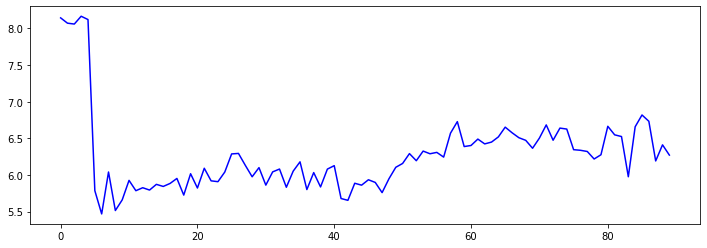

In [71]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(RBEM_pred['RBEM_test_pred'], color='blue')
plt.show()